# 2.1 Web Services

In [1]:
import requests

In [2]:
result = requests.get("http://cat-fact.herokuapp.com/facts/random")

In [3]:
print(result)

<Response [200]>


In [4]:
print(result.json())

{'used': False, 'source': 'api', 'type': 'cat', 'deleted': False, '_id': '591f98703b90f7150a19c134', '__v': 0, 'text': 'Statistics indicate that animal lovers in recent years have shown a preference for cats over dogs!', 'updatedAt': '2020-05-10T20:20:11.457Z', 'createdAt': '2018-01-04T01:10:54.673Z', 'status': {'verified': True, 'sentCount': 1}, 'user': '5a9ac18c7478810ea6c06381'}


In [5]:
print(result.json()['text'])

Statistics indicate that animal lovers in recent years have shown a preference for cats over dogs!


## Echo Service

Instead of running this in a Jupyter notebook, we’ll save the script as a file called echo.py.

In [1]:
!cat scripts/echo.py

# load Flask 
import flask
app = flask.Flask(__name__)

# define a predict function as an endpoint 
@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    
    # check for passed in parameters   
    params = flask.request.json
    if params is None:
        params = flask.request.args
    
    # if parameters are found, echo the msg parameter 
    if "msg" in params.keys(): 
        data["response"] = params.get("msg")
        data["success"] = True
        
    # return a response in json format 
    return flask.jsonify(data)
    
# start the flask app, allow remote connections
if __name__ == '__main__':
    app.run(host='0.0.0.0')


## Call the Service

In [2]:
import os
import requests

In [3]:
HOST = os.environ['HOSTNAME']

In [4]:
result = requests.get(url=f"http://{HOST}:5000/")
print(result.json())

{'success': False}


In [5]:
result = requests.get(url=f"http://{HOST}:5000/?msg=Hello from URL!")
print(result.json())

{'response': 'Hello from URL!', 'success': True}


In [6]:
result = requests.get(url=f"http://{HOST}:5000/",
                      params={'msg': 'Hello from params'})
print(result.json())

{'response': 'Hello from params', 'success': True}


In [7]:
result = requests.post(url=f"http://{HOST}:5000/",
                       json={'msg': 'Hello from data'})
print(result.json())

{'response': 'Hello from data', 'success': True}


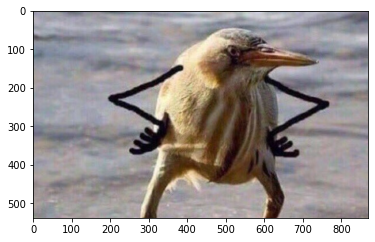

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64

HOST = 'localhost'

image = open("meme.jpg", "rb").read()
encoded = base64.b64encode(image)
result = requests.post(url=f"http://{HOST}:5000/", 
                       json={'msg': encoded})

encoded = result.json()['response']
imgData = base64.b64decode(encoded)
plt.imshow(np.array(Image.open(io.BytesIO(imgData))))
plt.show()

# 2.2 Model Persistence

## Scikit-Learn

In [32]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv")
x = df.drop(['label'], axis=1)
y = df['label']

model = LogisticRegression()
model.fit(x, y)

LogisticRegression()

In [33]:
# preferred approach
# https://scikit-learn.org/stable/modules/model_persistence.html
import joblib

joblib.dump(model, 'logit.pkl')

model = joblib.load('logit.pkl')
model.predict_proba(x)

array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427],
       [0.85766917, 0.14233083],
       ...,
       [0.89969047, 0.10030953],
       [0.85766917, 0.14233083],
       [0.89969047, 0.10030953]])

In [34]:
# standard approach
# https://scikit-learn.org/stable/modules/model_persistence.html
import pickle

pickle.dump(model, open("logit.pkl", 'wb'))

model = pickle.load(open("logit.pkl", 'rb'))
model.predict_proba(x)

array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427],
       [0.85766917, 0.14233083],
       ...,
       [0.89969047, 0.10030953],
       [0.85766917, 0.14233083],
       [0.89969047, 0.10030953]])

## ML Flow

In [35]:
import mlflow
import mlflow.sklearn
import shutil

model_path = "models/logit_games_v1"
shutil.rmtree(model_path)
mlflow.sklearn.save_model(model, model_path)

loaded = mlflow.sklearn.load_model(model_path)
loaded.predict_proba(x)

array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427],
       [0.85766917, 0.14233083],
       ...,
       [0.89969047, 0.10030953],
       [0.85766917, 0.14233083],
       [0.89969047, 0.10030953]])

## Keras

In [36]:
import tensorflow as tf
import tensorflow.keras as K
from sklearn.model_selection import train_test_split

# create train and test splits of the game data set 
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, 
    y_train_val, 
    test_size=0.2,
    random_state=42,
    stratify=y_train_val
)

# define the network structure 
model = K.models.Sequential()
model.add(K.layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(K.layers.Dropout(0.1))
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dense(1, activation='sigmoid'))
    
# compile and fit the model    
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[K.metrics.AUC(name='auc')])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=100, verbose=0)

In [37]:
model.save("games.h5")

model = K.models.load_model('games.h5')
model.evaluate(x_test, y_test, verbose=0)

[0.3076595962047577, 0.8173983693122864]

In [39]:
import mlflow.keras
import shutil

model_path = "models/keras_games_v1"
shutil.rmtree(model_path)
mlflow.keras.save_model(model, model_path)

loaded = mlflow.keras.load_model(model_path)
loaded.evaluate(x_test, y_test, verbose=0)

[0.3076595962047577, 0.8173983693122864]

# 2.3 Model Endpoints

In [1]:
import os

In [2]:
HOST = os.environ['HOSTNAME']

## Scikit-Learn

In [26]:
!cat scripts/predict.py

# import pickle
import flask
import mlflow
import mlflow.sklearn
import pandas as pd

#from sklearn.linear_model import LogisticRegression


# model = pickle.load(open("logit.pkl", 'rb'))
model_path = "models/logit_games_v1"
model  = mlflow.sklearn.load_model(model_path)


app = flask.Flask(__name__)

@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    params = flask.request.args

    if "G1" in params.keys(): 
        new_row = {"G1": params.get("G1"), "G2": params.get("G2"), 
                   "G3": params.get("G3"), "G4": params.get("G4"), 
                   "G5": params.get("G5"), "G6": params.get("G6"), 
                   "G7": params.get("G7"), "G8": params.get("G8"), 
                   "G9": params.get("G9"), "G10":params.get("G10")}

        new_x = pd.DataFrame.from_dict(data=new_row, 
                                       orient="index",
                                       dtype="float").T
        
        data["response"] = str(mo

In [29]:
import requests

new_row = {"G1": 0, "G2": 0, "G3": 0, "G4": 0, "G5": 0,
           "G6": 0, "G7": 0, "G8": 0, "G9": 0, "G10": 1}

result = requests.get(f"http://{HOST}:5000/", params=new_row)
print(result.json()['response'])

0.38090005964959933


## Keras

In [30]:
!cat scripts/keras_games.py

import flask
import mlflow
import mlflow.keras
import pandas as pd
import tensorflow.keras as K


model_path = "models/keras_games_v1"
model = mlflow.keras.load_model(model_path)

app = flask.Flask(__name__)

@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    params = flask.request.args

    if "G1" in params.keys(): 
        new_row = {"G1": params.get("G1"), "G2": params.get("G2"), 
                   "G3": params.get("G3"), "G4": params.get("G4"), 
                   "G5": params.get("G5"), "G6": params.get("G6"), 
                   "G7": params.get("G7"), "G8": params.get("G8"), 
                   "G9": params.get("G9"), "G10": params.get("G10")}
        
        new_x = pd.DataFrame.from_dict(data=new_row,   
                                       orient="index", 
                                       dtype="float").T
     
        data["response"] = str(model.predict(new_x)[0][0])
        data["success"] = True

    return flask.jsonify(da

In [33]:
import requests

new_row = {"G1": 0, "G2": 0, "G3": 0, "G4": 0, "G5": 0,
           "G6": 0, "G7": 0, "G8": 0, "G9": 0, "G10": 1}

result = requests.get(f"http://{HOST}:5000/", params=new_row)
print(result.json()['response'])

0.26674467


# 2.4 Deploying a Web Endpoint

## Gunicorn

In [1]:
# !gunicorn --bind 0.0.0.0 --chdir scripts/ echo:app

In [4]:
import os
import requests

HOST = os.environ['HOSTNAME']

result = requests.get(f"http://{HOST}:8000/",
                      params={'msg': 'Hello from Gunicorn'})
print(result.json())

{'response': 'Hello from Gunicorn', 'success': True}


## Heroku

In [2]:
!cat scripts/heroku/00_install.sh

#!/usr/bin/env bash

cd ~
curl -o heroku-linux-x64.tar.gz https://cli-assets.heroku.com/heroku-linux-x64.tar.gz
tar xzf heroku-linux-x64.tar.gz
cd ~/.local/bin/ && ln -s ~/heroku/bin/heroku heroku

sudo yum update
sudo yum -y install glibc.i686

heroku --version


In [3]:
!cat scripts/heroku/01_create.sh

#!/usr/bin/env bash

heroku login -i
heroku create


In [4]:
!cat scripts/heroku/02_setup.sh

#!/usr/bin/env bash

sudo yum update
sudo yum install gcc python-setuptools postgresql-devel

sudo easy_install psycopg2

pip install --user django
pip install --user django-heroku


In [5]:
!cat scripts/heroku/03_sample.sh

#!/usr/bin/env bash

sudo yum update
sudo yum install git

cd ~
git clone https://github.com/heroku/python-getting-started.git


In [6]:
!cat scripts/heroku/04_local.sh

#!/usr/bin/env bash

cd ~/python-getting-started
cp ~/ds-production/source/scripts/echo.py echo.py
echo 'flask' >> requirements.txt
echo "web: gunicorn echo:app" > Procfile

heroku local


In [7]:
import requests

result = requests.get("http://localhost:5000/", 
                      params={'msg': 'Hello from Heroku Local'})
print(result.json())

{'response': 'Hello from Heroku Local', 'success': True}


In [8]:
!cat scripts/heroku/05_prod.sh

#!/usr/bin/env bash

cd ~/python-getting-started

heroku git:remote -a warm-plains-93636
git add .
git commit -m "Test echo service"
git push heroku master

heroku ps:scale web=1


In [9]:
import requests

result = requests.get("https://warm-plains-93636.herokuapp.com/",
                      params={'msg': 'Hello from Heroku Prod'})
print(result.json())

{'response': 'Hello from Heroku Prod', 'success': True}


# 2.5 Interactive Web Services

## Dash

In [34]:
!cat scripts/dash_app.py

import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import pandas as pd
import mlflow.sklearn

app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Model UI'),
    html.P([
        html.Label('Game 1 '),
        dcc.Input(value='1', type='text', id='g1'),
    ]),
    html.Div([
        html.Label('Game 2 '),
        dcc.Input(value='0', type='text', id='g2'),
    ]),
    html.P([
        html.Label('Prediction '),
        dcc.Input(value='0', type='text', id='pred')
    ]),
])

model_path = "models/logit_games_v1"
model  = mlflow.sklearn.load_model(model_path)

@app.callback(
    Output(component_id='pred', component_property='value'),
    [Input(component_id='g1', component_property='value'),
     Input(component_id='g2', component_property='value')]
)
def update_prediction(game1, game2):

    new_row = {"G1": float(game1), 
               "G2": float(game2), 
               "G3": 0

In [35]:
import pandas as pd
import mlflow.sklearn


model_path = "models/logit_games_v1"
model  = mlflow.sklearn.load_model(model_path)


def update_prediction(game1, game2):

    new_row = {"G1": float(game1), 
               "G2": float(game2), 
               "G3": 0, "G4": 0, 
               "G5": 0, "G6": 0, 
               "G7": 0, "G8": 0, 
               "G9": 0, "G10": 0}

    new_x = pd.DataFrame.from_dict(data=new_row,
                                   orient="index", 
                                   dtype="float").T                
    
    return str(model.predict_proba(new_x)[0][1])    

update_prediction(1, 0)

'0.06730006696024816'